# Initialisation

In [1]:
%matplotlib ipympl
from matplotlib import pyplot as plt
import numpy as np
from astropy.io import fits


In [51]:
def find_mode_and_threshold(x, weights=None, fig_name=None):
    if weights is None:
        weights = np.ones_like(x)

    valid = np.where(np.isfinite(x) & np.isfinite(weights))
    n_valid = valid[0].size
    sorted_by_x = np.argsort(x[valid].flatten())
    sorted_x = x[valid].flatten()[sorted_by_x]
    sorted_weight = weights[valid].flatten()[sorted_by_x]

    cumulative_mass = np.cumsum(sorted_weight)
    total_mass = cumulative_mass[-1]
    sorted_weight /= total_mass
    cumulative_mass /= total_mass
    
    
    nbins = int(np.sqrt(4*n_valid + 1) - 1)
    m_left = np.linspace(0, 0.5, nbins)[1:-1]
    m_mid = 2 * m_left
    m_right = 0.5 + m_left

    x_left = np.interp(m_left, cumulative_mass, sorted_x)
    x_mid = np.interp(m_mid, cumulative_mass, sorted_x)
    x_right = np.interp(m_right, cumulative_mass, sorted_x)

    h = np.fmin(x_right-x_mid, x_mid-x_left)
    rho = (np.interp(x_mid+h, sorted_x, cumulative_mass) - np.interp(x_mid-h, sorted_x, cumulative_mass)) /2/h

    rho_threshold = np.nanpercentile(rho, 100*(1 - 1/np.sqrt(nbins)))
    peak_region = x_mid[rho > rho_threshold]
    index_min = np.searchsorted(sorted_x, np.min(peak_region))
    index_max = np.searchsorted(sorted_x, np.max(peak_region))
    index_mode = (index_min+index_max) // 2
    mode = sorted_x[index_mode]
    m_mode = cumulative_mass[index_mode]
    
    rho_bg = np.fmin(rho, np.interp(x_mid, (2*mode - x_mid)[::-1], rho[::-1], left=0, right=0))
    total_bg = 2 * m_mode
    threshold = sorted_x[int(n_valid * total_bg)]

    if fig_name is not None:
        plt.close(fig_name)
        fig = plt.figure(fig_name, figsize=(8, 5))
        axes = fig.subplots(nrows=1, ncols=1, squeeze=False,
                            sharex='col', sharey='row',
                            gridspec_kw={'hspace': 0, 'wspace': 0},
                           )

        ax = axes[0, 0]
        ax.set_ylabel('probability density')
        #ax.set_yscale('log')
        ax.plot(x_mid, rho-rho_bg, 'b-', alpha=.5, label='signal')
        ax.plot(x_mid, rho_bg, 'r-', alpha=.5, label='background')
        ax.plot(x_mid, rho, 'k-', alpha=.5, label='total')


        ax.set_xlabel('value')
        ax.set_xlim(x_mid[0], threshold + 5*(threshold - mode))

        for ax in axes.flatten():
            ax.tick_params(which='both', bottom=True, top=True, left=True, right=True)
            ax.tick_params(which='major', direction='inout', length=8, grid_alpha=.3)
            ax.tick_params(which='minor', direction='in', length=2, grid_alpha=.1)
            ax.grid(True, which='both')
            ax.axvspan(sorted_x[index_min], sorted_x[index_max], color='k', alpha=.1)
            ax.axvline(mode, c='k', ls=':', label=f'mode = {mode:.4g}')
            ax.axvline(threshold, c='b', ls='-.', label=f'threshold = {threshold:.4g}')
            ax.axvline(2*mode - threshold, c='r', ls='-.', alpha=.5)
            ax.legend()

        fig.suptitle(fig_name)
        fig.set_tight_layout(True)
        plt.show()
        
    return mode, threshold

# AGN classification

In [52]:
excess = np.genfromtxt('data/excesses.csv', delimiter=',',
                      dtype={'names': ('IR1', 'IR2', 'IR4', 'Radio', 'Soft X', 'Hard X', 'IR color','Radio color', 'X color'),
                            'formats': ('f', 'f', 'f', 'f', 'f', 'f', 'f', 'f', 'f')}
                      )

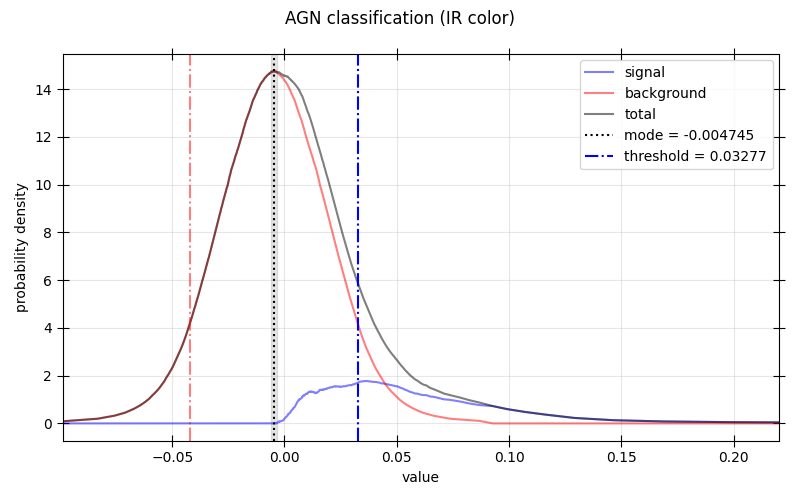

(-0.0047454783, 0.032765273)

In [53]:
find_mode_and_threshold(excess['IR_color'], fig_name='AGN classification (IR color)')

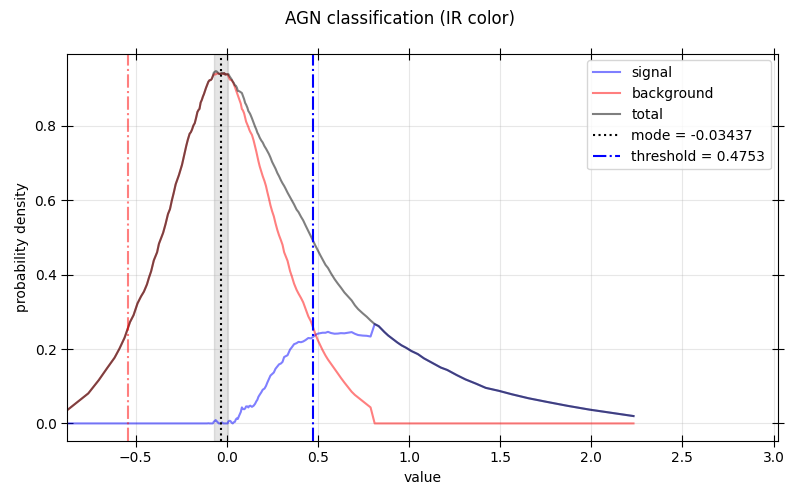

(-0.034370646, 0.4752809)

In [54]:
find_mode_and_threshold(excess['Radio_color'], fig_name='AGN classification (IR color)')

# Source finding

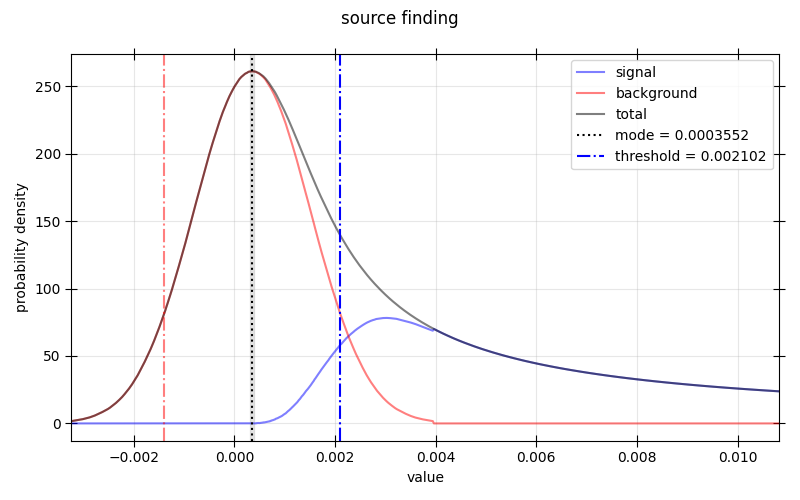

(0.00035521257, 0.0021016097)

In [55]:
hdu = fits.open('data/CIG_335.fits')
img = hdu[0].data[3000:4000, 1500:2500] * 1.  # to make sure it's converted to float

find_mode_and_threshold(img, fig_name='source finding')